<a href="https://colab.research.google.com/github/Nadim-Hasan/X-ray-image-Classification-pneumonia-detection/blob/main/Xray_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nadimhasan00","key":"aab5174c540286a64db677767cfa18df"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                              Data Science Salaries 2023 💸                       25KB  2023-04-13 09:55:16           9489        254  1.0              
asahu40/walmart-data-analysis-and-forcasting                       Walmart Data Analysis and Forcasting              122KB  2023-04-26 07:07:03           1192         31  1.0              
ahmedshahriarsakib/usa-real-estate-dataset                         USA Real Estate Dataset                             1MB  2023-04-30 03:51:36            913         28  1.0              
iammustafatz/diabetes-prediction-dataset               

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:38<00:00, 49.1MB/s]
100% 2.29G/2.29G [00:38<00:00, 64.7MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from yellowbrick.model_selection import learning_curve


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle as shf
import pickle
import os
import glob as gb

In [ ]:
code = {'NORMAL':0 ,'PNEUMONIA':1}
#function to return the class of the images from its number, so the function would return 'Normal' if given 0, and 'PNEUMONIA' if given 1.
def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

In [ ]:
#the directory that contain the train images set
trainpath='/content/chest_xray/train/'

X_train = []
y_train = []
for folder in  os.listdir(trainpath) : 
    files = gb.glob(pathname= str( trainpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        X_train.append(list(image_array))
        y_train.append(code[folder])
np.save('X_train',X_train)
np.save('y_train',y_train)

In [ ]:
#the directory that contain the test images set
testpath='/content/chest_xray/test/'

X_test = []
y_test = []
for folder in  os.listdir(testpath) : 
    files = gb.glob(pathname= str( testpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        X_test.append(list(image_array))
        y_test.append(code[folder])
np.save('X_test',X_test)
np.save('y_test',y_test)

In [ ]:
#X_train, X_test contain the images as numpy arrays, while y_train, y_test contain the class of each image 
loaded_X_train = np.load('./X_train.npy')
loaded_X_test = np.load('./X_test.npy')
loaded_y_train = np.load('./y_train.npy')
loaded_y_test = np.load('./y_test.npy')

In [ ]:
print(loaded_X_train.shape)
#the shape return dimensions of X_train, we have 5216 images of 64 x 64 pixels. 
#while the forth dimension stores the RGB information of each pixel

(5216, 64, 64, 3)


In [ ]:
print(loaded_X_test.shape)

(624, 64, 64, 3)


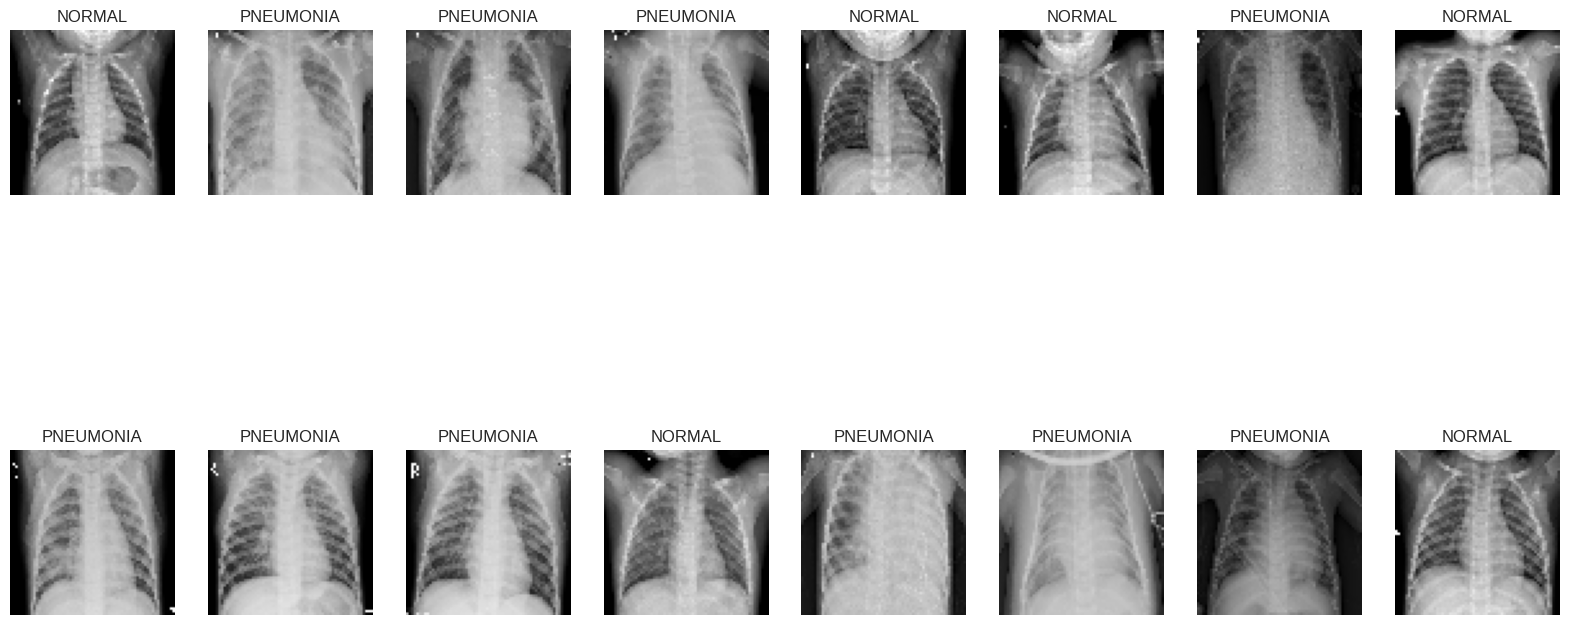

In [ ]:
#plotting images of NORMAL and PNEUMONIA
plt.figure(figsize=(20,10))
for n , i in enumerate(np.random.randint(0,len(loaded_X_train),16)): 
    plt.subplot(2,8,n+1)
    plt.imshow(loaded_X_train[i])
    plt.axis('off')
    plt.title(getcode(loaded_y_train[i]))

In [ ]:
#function to plot the pixel intensity of each image. 
def plotHistogram(a):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5)
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5)
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5)

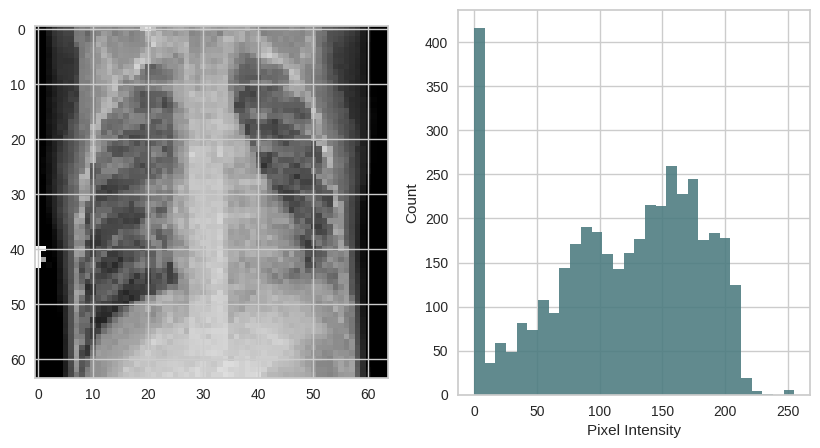

In [ ]:
plotHistogram(loaded_X_train[np.random.randint(len(loaded_X_train))])

In [ ]:
#flatten the images into a 2d array, for model training and testing
X_train = loaded_X_train.reshape([-1, np.product((64,64,3))])
X_test = loaded_X_test.reshape([-1, np.product((64,64,3))])

In [ ]:
print(X_train.shape)
print(X_test.shape)

(5216, 12288)
(624, 12288)


In [ ]:
y_train = loaded_y_train
y_test = loaded_y_test

In [ ]:
#shuffle train and test data sets in a consistent way
X_train, y_train = shf(X_train, y_train, random_state=15)
X_test, y_test = shf(X_test, y_test, random_state=15)

In [ ]:
#making an instance of each algorithm
knn = KNeighborsClassifier(n_neighbors=10)
log_reg  = LogisticRegression()
dtc  = DecisionTreeClassifier()
rfc = RandomForestClassifier()
svm = SVC()

In [ ]:
#fitting each model using X_train and y_train
knn.fit(X_train, y_train)
log_reg.fit(X_train, y_train)
dtc.fit(X_train, y_train)
rfc.fit(X_train, y_train)
svm.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC()

In [ ]:
#scoring each model
print('KNN accuracy score is: ' + str(knn.score(X_test, y_test)))
print('Logistic Regression accuracy score is: ' + str(log_reg.score(X_test, y_test)))
print('Decision Tree Classifier accuracy score is: ' + str(dtc.score(X_test, y_test)))
print('Random forests Classifier accuracy score is: ' + str(rfc.score(X_test, y_test)))
print('Support Vector Machine Classifier accuracy score is: ' + str(svm.score(X_test, y_test)))

KNN accuracy score is: 0.7339743589743589
Logistic Regression accuracy score is: 0.7451923076923077
Decision Tree Classifier accuracy score is: 0.7355769230769231
Random forests Classifier accuracy score is: 0.7644230769230769
Support Vector Machine Classifier accuracy score is: 0.7612179487179487


In [ ]:
#making predictions for each model
knn_predcited = knn.predict(X_test)
log_reg_predcited = log_reg.predict(X_test)
dtc_predcited = dtc.predict(X_test)
rfc_predcited = rfc.predict(X_test)
svm_predcited = svm.predict(X_test)

In [ ]:
X_train = X_train.reshape(-1, 64, 64, 3)
X_test = X_test.reshape(-1, 64, 64, 3)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))

# Add a pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a fully connected layer with 128 neurons
model.add(Dense(128, activation='relu'))

# Add a dropout layer for regularization
model.add(Dropout(0.5))

# Add the output layer with a sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
from keras.callbacks import ModelCheckpoint

# Define the checkpoint filepath
checkpoint_filepath = '/path/to/checkpoint'

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)

In [ ]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test),callbacks=[checkpoint])

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)


Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8909
Epoch 1: val_loss improved from inf to 0.91262, saving model to /path/to/checkpoint
163/163 [==============================] - 45s 279ms/step - loss: 0.2917 - accuracy: 0.8909 - val_loss: 0.9126 - val_accuracy: 0.7516
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 0.1444 - accuracy: 0.9479
Epoch 2: val_loss improved from 0.91262 to 0.81918, saving model to /path/to/checkpoint
163/163 [==============================] - 38s 235ms/step - loss: 0.1444 - accuracy: 0.9479 - val_loss: 0.8192 - val_accuracy: 0.7772
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9534
Epoch 3: val_loss did not improve from 0.81918
163/163 [==============================] - 39s 240ms/step - loss: 0.1273 - accuracy: 0.9534 - val_loss: 1.1049 - val_accuracy: 0.7404
Epoch 4/10
163/163 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.

In [ ]:
#function to plot the confusion matrix for each model
def plot_cm(predictions, y_test, title):
  labels = ['Normal', 'Pnuemonia']
  cm = confusion_matrix(y_test,predictions)
  cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
  plt.figure(figsize = (7,7))
  plt.title(title)
  sns.heatmap(cm, linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)
  plt.show()

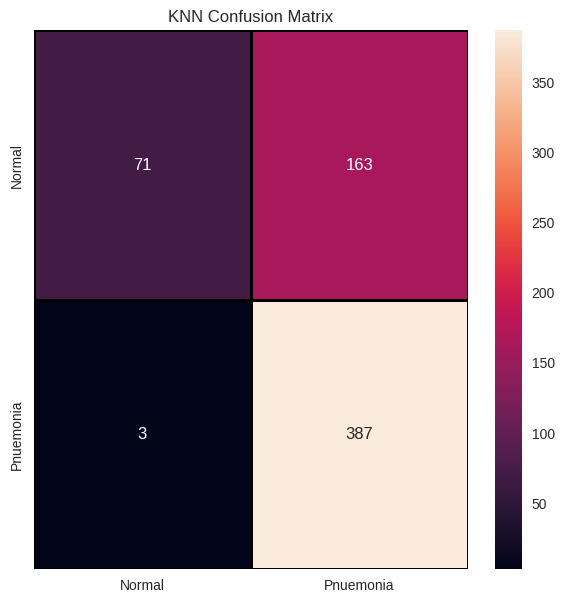

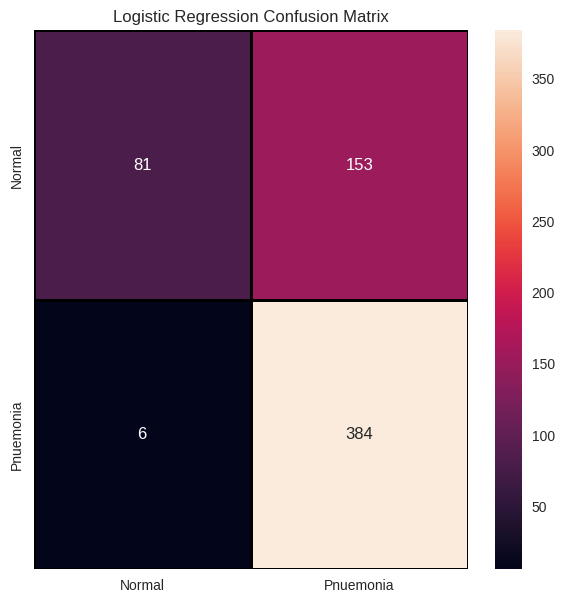

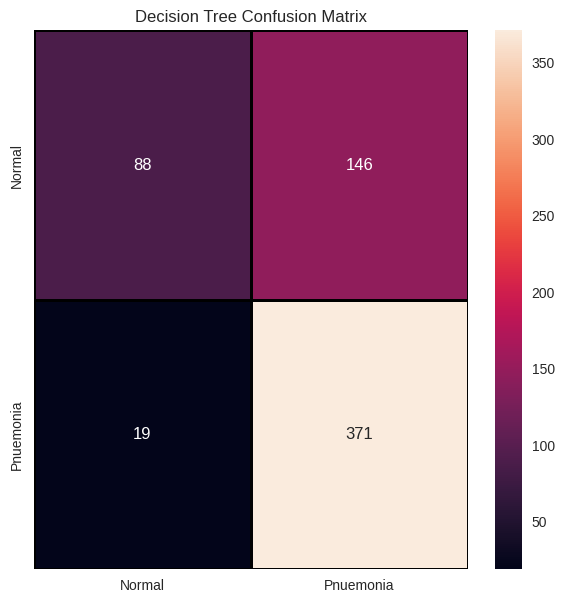

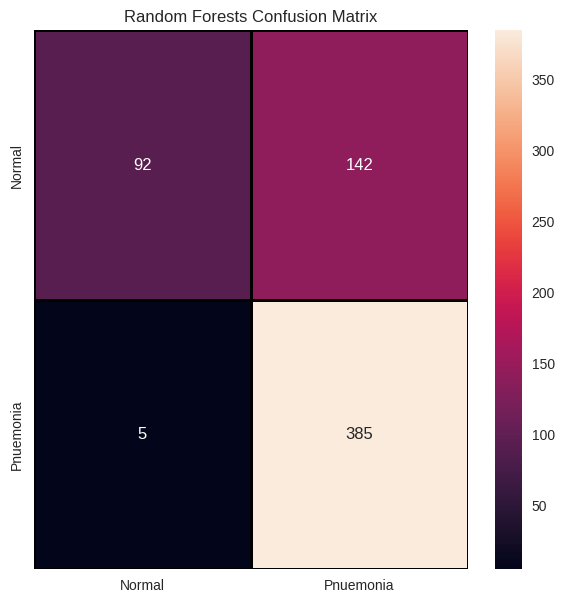

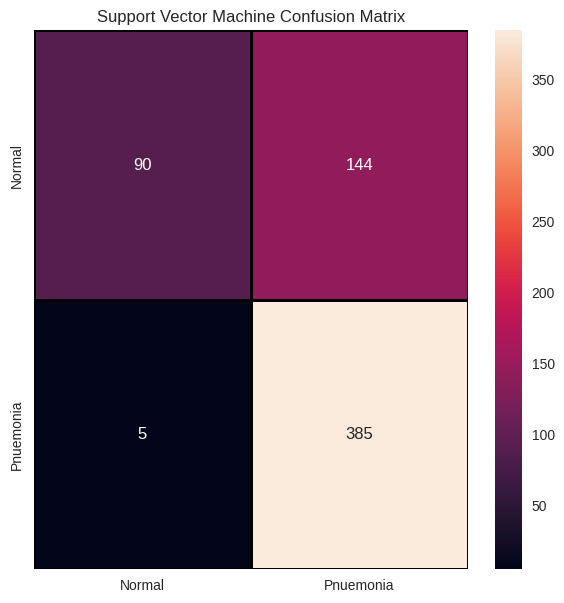

In [ ]:
##plot confusion matrix for each model

plot_cm(knn_predcited, y_test, 'KNN Confusion Matrix')

plot_cm(log_reg_predcited, y_test, 'Logistic Regression Confusion Matrix') 
    
plot_cm(dtc_predcited, y_test, 'Decision Tree Confusion Matrix')

plot_cm(rfc_predcited, y_test, 'Random Forests Confusion Matrix')

plot_cm(svm_predcited, y_test, 'Support Vector Machine Confusion Matrix')
#plot_cm(CNN_predict, X_test, 'CNN Vector Machine Confusion Matrix')

In [ ]:
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
  data_dir =       '/content/chest_xray/train/'

filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df

,filepaths,labels
0,/content/chest_xray/train/NORMAL/NORMAL2-IM-11...,NORMAL
1,/content/chest_xray/train/NORMAL/NORMAL2-IM-04...,NORMAL
2,/content/chest_xray/train/NORMAL/NORMAL2-IM-13...,NORMAL
3,/content/chest_xray/train/NORMAL/IM-0311-0001....,NORMAL
4,/content/chest_xray/train/NORMAL/NORMAL2-IM-08...,NORMAL
...,...,...
5211,/content/chest_xray/train/PNEUMONIA/person1539...,PNEUMONIA
5212,/content/chest_xray/train/PNEUMONIA/person1598...,PNEUMONIA
5213,/content/chest_xray/train/PNEUMONIA/person315_...,PNEUMONIA
5214,/content/chest_xray/train/PNEUMONIA/person44_b...,PNEUMONIA


In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 626 validated image filenames belonging to 2 classes.
Found 418 validated image filenames belonging to 2 classes.


In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 4,383,141
Trainable params: 4,338,558
Non

In [ ]:
batch_size = 16   # set batch size for training
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False,callbacks=[checkpoint])

Epoch 1/10
261/261 [==============================] - ETA: 0s - loss: 4.7371 - accuracy: 0.9255
Epoch 1: val_loss did not improve from 0.81918
261/261 [==============================] - 1568s 6s/step - loss: 4.7371 - accuracy: 0.9255 - val_loss: 3.2244 - val_accuracy: 0.8387
Epoch 2/10
261/261 [==============================] - ETA: 0s - loss: 2.3464 - accuracy: 0.9631
Epoch 2: val_loss did not improve from 0.81918
261/261 [==============================] - 1470s 6s/step - loss: 2.3464 - accuracy: 0.9631 - val_loss: 1.8774 - val_accuracy: 0.9313
Epoch 3/10
261/261 [==============================] - ETA: 0s - loss: 1.4806 - accuracy: 0.9763
Epoch 3: val_loss did not improve from 0.81918
261/261 [==============================] - 1427s 5s/step - loss: 1.4806 - accuracy: 0.9763 - val_loss: 1.1404 - val_accuracy: 0.9952
Epoch 4/10
261/261 [==============================] - ETA: 0s - loss: 0.9649 - accuracy: 0.9823
Epoch 4: val_loss improved from 0.81918 to 0.73614, saving model to /path/to

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

11/11 [==============================] - 33s 3s/step - loss: 0.1485 - accuracy: 0.9904
Train Loss:  0.13252496719360352
Train Accuracy:  1.0
--------------------
Validation Loss:  0.13759051263332367
Validation Accuracy:  1.0
--------------------
Test Loss:  0.14850080013275146
Test Accuracy:  0.9904305934906006


In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

11/11 [==============================] - 32s 3s/step - loss: 0.1485 - accuracy: 0.9904
Train Loss:  0.13045702874660492
Train Accuracy:  1.0
--------------------
Validation Loss:  0.14279040694236755
Validation Accuracy:  0.9886363744735718
--------------------
Test Loss:  0.14850080013275146
Test Accuracy:  0.9904305934906006


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

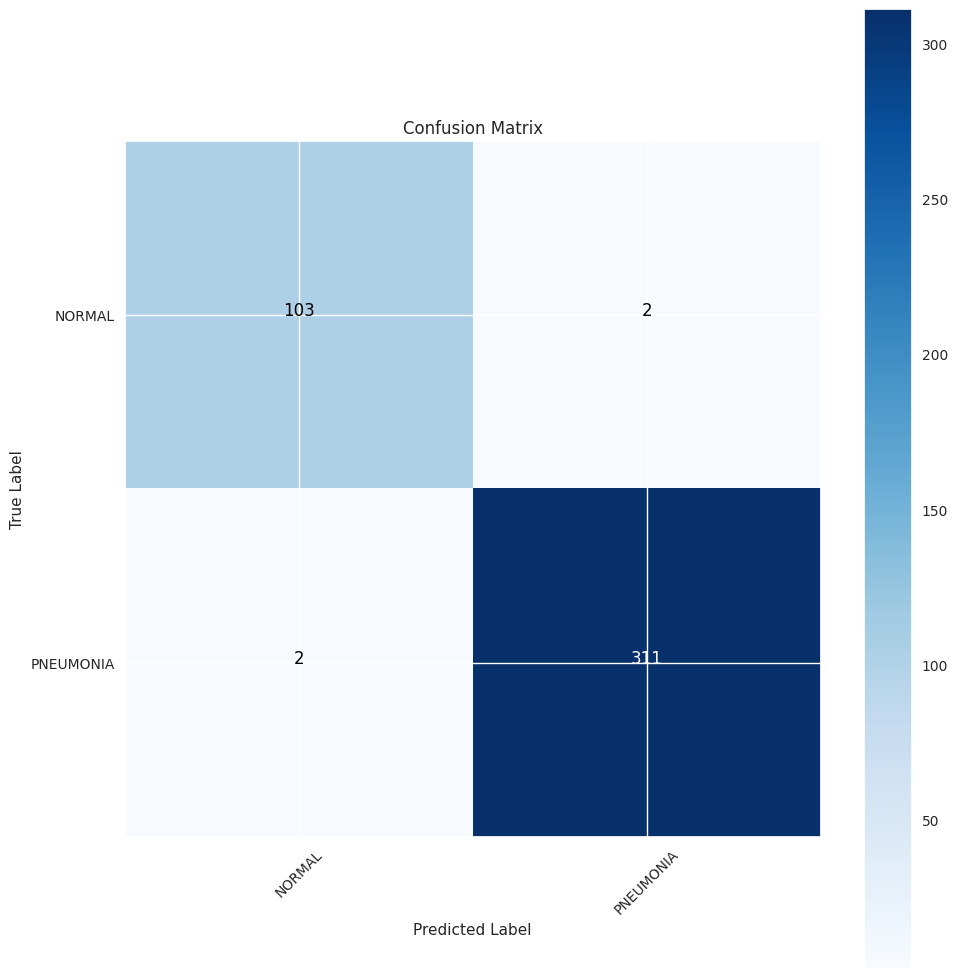

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
print ("bye")

bye
